In [39]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import norm
from IPython.display import display


In [40]:
image_name="0080.jpg"
# Load the image
image_path = "rawimage/"+image_name
color_image = Image.open(image_path)


In [41]:

# Convert the image to grayscale
gray_image = color_image.convert("L")
gray_image_array=np.array(gray_image)


In [42]:

# Save the grayscale image
gray_image_path = "grayimages/"+image_name
gray_image.save(gray_image_path)


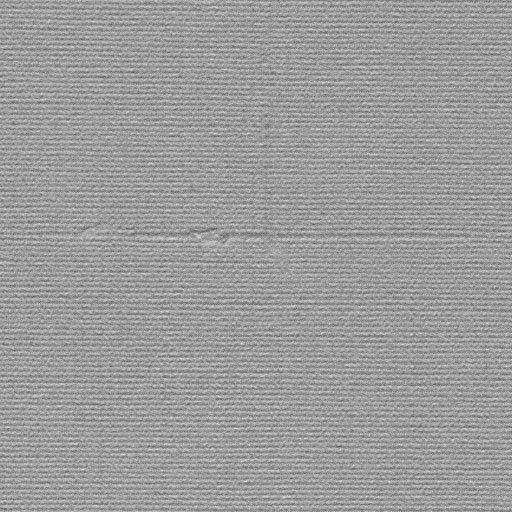

In [43]:
# Display the grayscale image
display(gray_image)

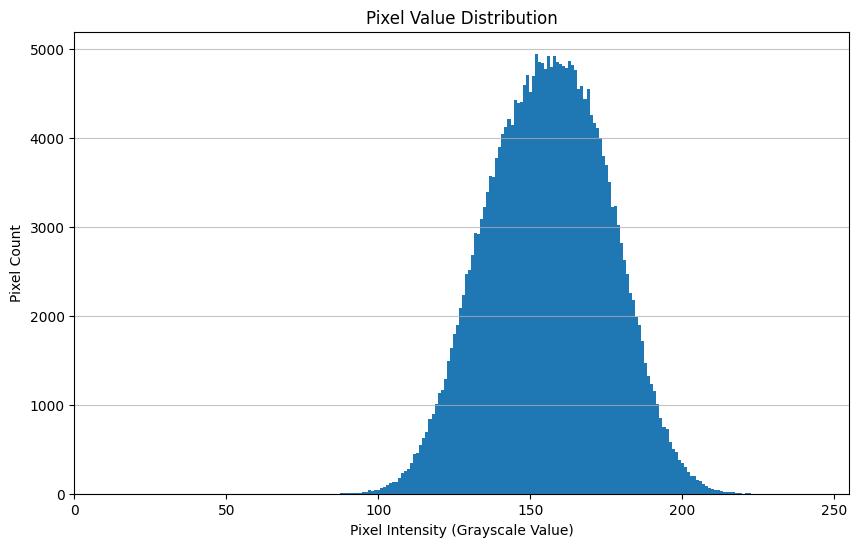

In [44]:
# Calculate the histogram of the grayscale image
histogram = gray_image.histogram()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(range(256), histogram, width=1, edgecolor="none")
plt.title("Pixel Value Distribution")
plt.xlabel("Pixel Intensity (Grayscale Value)")
plt.ylabel("Pixel Count")
plt.xlim(0, 255) # The range of grayscale values is from 0 (black) to 255 (white)
plt.grid(axis="y", alpha=0.75)
plt.show()


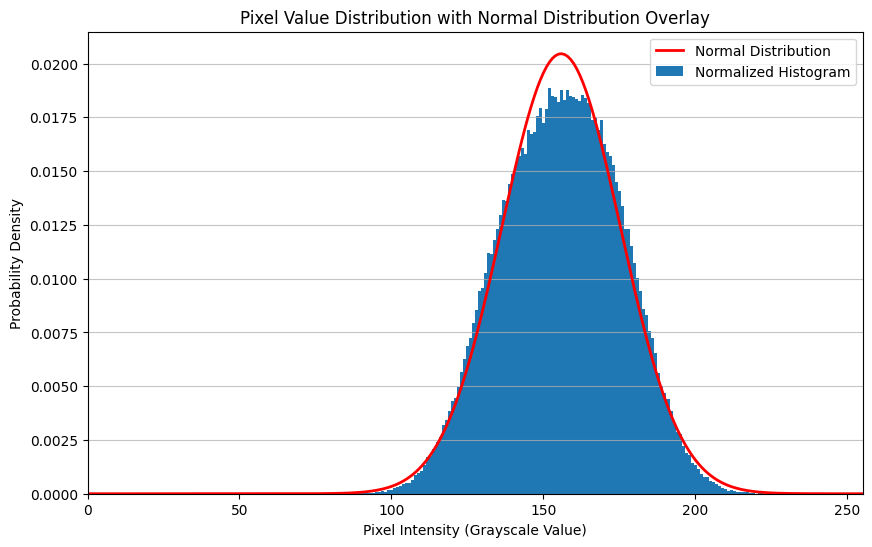

(155.81856155395508, 19.49987707277244)

In [45]:

# Calculate mean and standard deviation of the pixel intensities
pixel_values = np.array(gray_image).flatten()  # Flatten the 2D image into 1D pixel array
mean = np.mean(pixel_values)
std_dev = np.std(pixel_values)

# Generate a range of pixel values
pixel_range = np.arange(0, 256)

# Calculate the normal distribution with the same mean and standard deviation
normal_distribution = norm.pdf(pixel_range, mean, std_dev)

# Normalize the histogram to compare with the probability density function
histogram_normalized = histogram / (np.sum(histogram) * (pixel_range[1] - pixel_range[0]))

# Plot the histogram and the normal distribution
plt.figure(figsize=(10, 6))
plt.bar(pixel_range, histogram_normalized, width=1, edgecolor="none", label="Normalized Histogram")
plt.plot(pixel_range, normal_distribution, color="red", linewidth=2, label="Normal Distribution")
plt.title("Pixel Value Distribution with Normal Distribution Overlay")
plt.xlabel("Pixel Intensity (Grayscale Value)")
plt.ylabel("Probability Density")
plt.legend()
plt.xlim(0, 255)
plt.grid(axis="y", alpha=0.75)
plt.show()

mean, std_dev


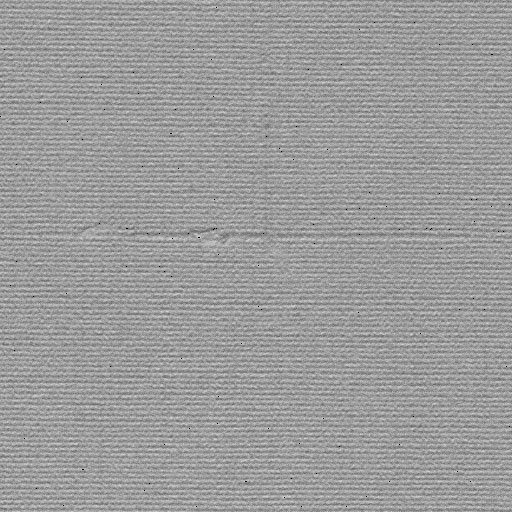

In [46]:
# Determine the lower and upper bounds for the 0.001 probability limits
lower_bound = norm.ppf(0.001, mean, std_dev)
upper_bound = norm.ppf(1-0.001, mean, std_dev)

# Identify pixels outside the bounds
outlier_pixels = np.logical_or(pixel_values < lower_bound, pixel_values > upper_bound)

# Create a copy of the pixel values to modify
modified_pixels = pixel_values.copy()

# Set the outlier pixels to 0 (black)
modified_pixels[outlier_pixels] = 0

# Reshape the modified pixels back to the original image shape
modified_image_array = modified_pixels.reshape(gray_image.size[::-1])
modified_image = Image.fromarray(modified_image_array)

# Display the original and modified images side by side
display(modified_image)


In [47]:
def DrawCircle(img,img_array,rad=3):
    copy_img=img.copy()
    draw = ImageDraw.Draw(copy_img)
    for idx, is_outlier in enumerate(img_array.flatten()):
        if is_outlier==0:
            x = idx % img.width
            y = idx // img.width
            radius = rad  # radius of the circle
            draw.ellipse((x-radius, y-radius, x+radius, y+radius), outline="red", width=1)
    display(copy_img)

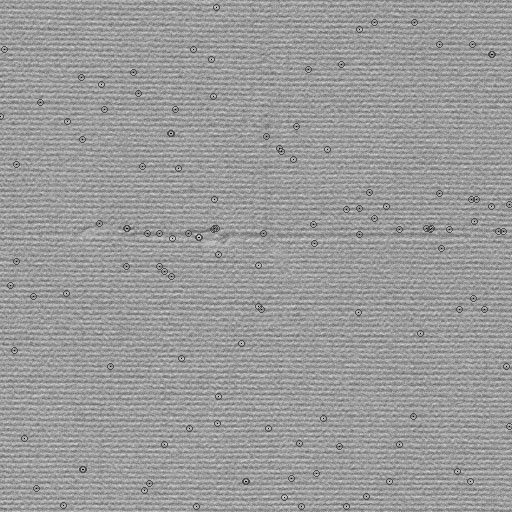

In [48]:
DrawCircle(modified_image,modified_image_array)

In [49]:
def modify_image_array(img_array):
    
    pixel_values = np.array(img_array).flatten()  # Flatten the 2D image into 1D pixel array
    mean = np.mean(pixel_values)
    std_dev = np.std(pixel_values)

    # Determine the lower and upper bounds for the 0.001 probability limits
    lower_bound = norm.ppf(0.001, mean, std_dev)
    upper_bound = norm.ppf(1-0.001, mean, std_dev)

    # Identify pixels outside the bounds
    outlier_pixels = np.logical_or(pixel_values < lower_bound, pixel_values > upper_bound)

    # Create a copy of the pixel values to modify
    modified_pixels = pixel_values.copy()

    # Set the outlier pixels to 0 (black)
    modified_pixels[outlier_pixels] = 0

    # Reshape the modified pixels back to the original image shape
    modified_image_array = modified_pixels.reshape(img_array.shape)
    return modified_image_array

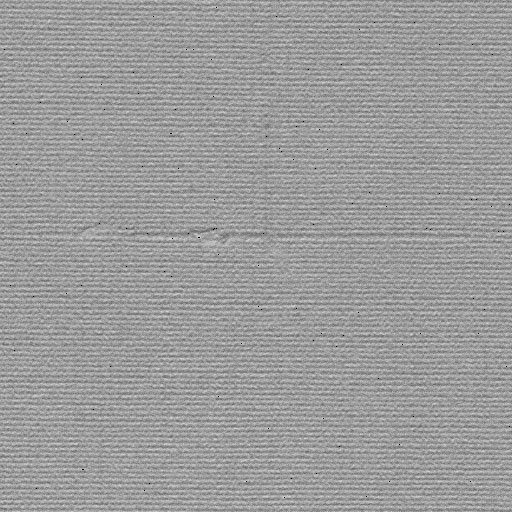

In [50]:
local_modified_image_array=gray_image_array.copy()

window_size=51

for i in range(1,gray_image_array.shape[0] - window_size+1,window_size):
    for j in range(1,gray_image_array.shape[1] - window_size+1,window_size):
        # Extract the local window
        local_window = gray_image_array[i:i + window_size,
                                    j:j +window_size]
        local_array = modify_image_array(local_window)
        local_modified_image_array[i:i + window_size,
                                    j:j +window_size]=local_array
        
local_modified_image = Image.fromarray(np.uint8(local_modified_image_array))

# Display the original and locally thresholded images side by side
display(local_modified_image)


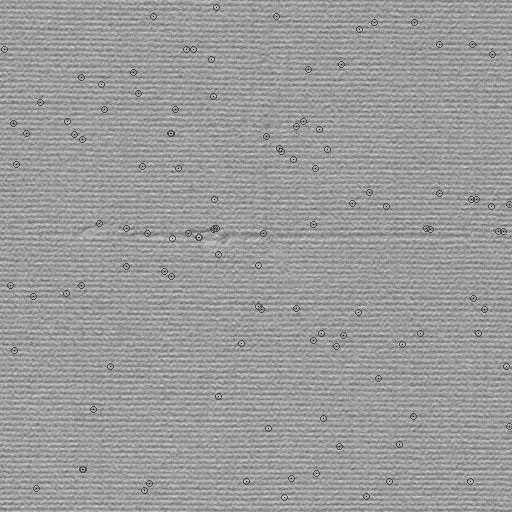

In [51]:
DrawCircle(local_modified_image,local_modified_image_array)

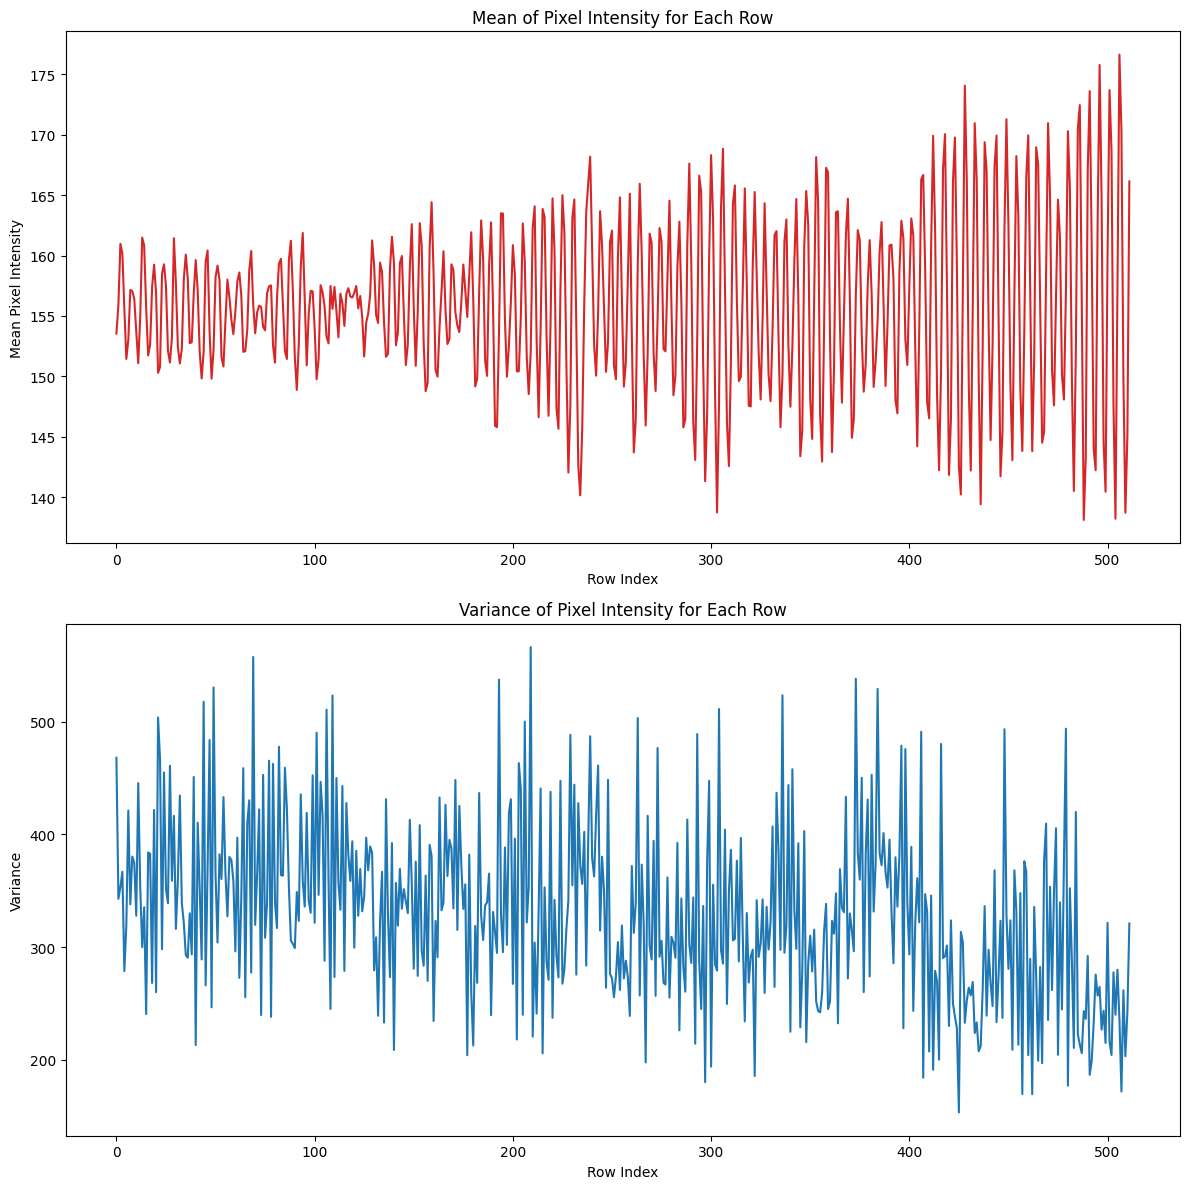

In [52]:
# Calculate the mean and variance for each row of the image
rows_mean = np.mean(gray_image, axis=1)
rows_variance = np.var(gray_image, axis=1)

# Plot the mean and variance for each row in separate plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot for mean
ax1.set_xlabel('Row Index')
ax1.set_ylabel('Mean Pixel Intensity')
ax1.plot(rows_mean, color='tab:red')
ax1.set_title('Mean of Pixel Intensity for Each Row')

# Plot for variance
ax2.set_xlabel('Row Index')
ax2.set_ylabel('Variance')
ax2.plot(rows_variance, color='tab:blue')
ax2.set_title('Variance of Pixel Intensity for Each Row')

fig.tight_layout()
plt.show()


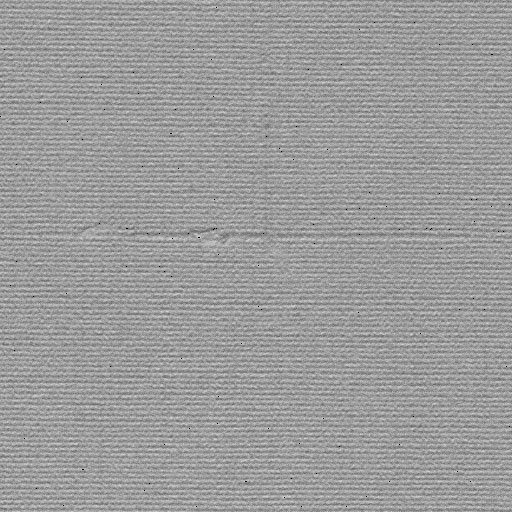

In [53]:
# Identify rows with out-of-control pixel values using 3-sigma rule
control_limit = 3 * np.sqrt(rows_variance)
upper_control_limit = rows_mean + control_limit
lower_control_limit = rows_mean - control_limit

gray_image_array=np.array(gray_image)
modified_image_rows_matrix=[]
for i, row in enumerate(gray_image_array):
    out_of_control_rows = np.logical_or(row > upper_control_limit[i], row < lower_control_limit[i])
    modified_image_rows_matrix.append(out_of_control_rows)

modified_pixels_rows = pixel_values.copy()

modified_image_rows_array=np.array(modified_image_rows_matrix)

modified_image_rows_array_flatten=modified_image_rows_array.flatten()
modified_pixels_rows[modified_image_rows_array_flatten] = 0

modified_image_rows = modified_pixels.reshape(gray_image.size[::-1])
modified_image_rows = Image.fromarray(modified_image_rows)

display(modified_image_rows)


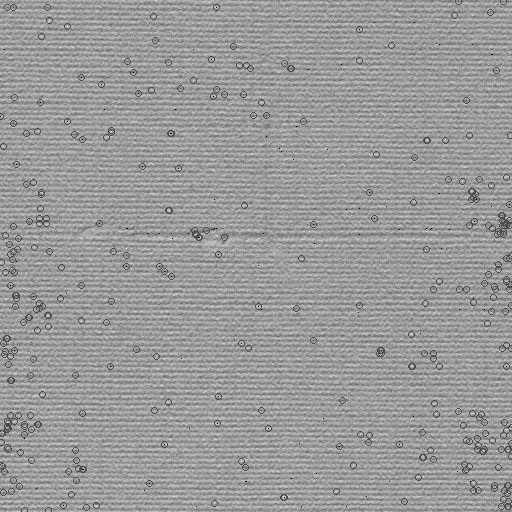

In [54]:
DrawCircle(modified_image_rows,modified_pixels_rows)

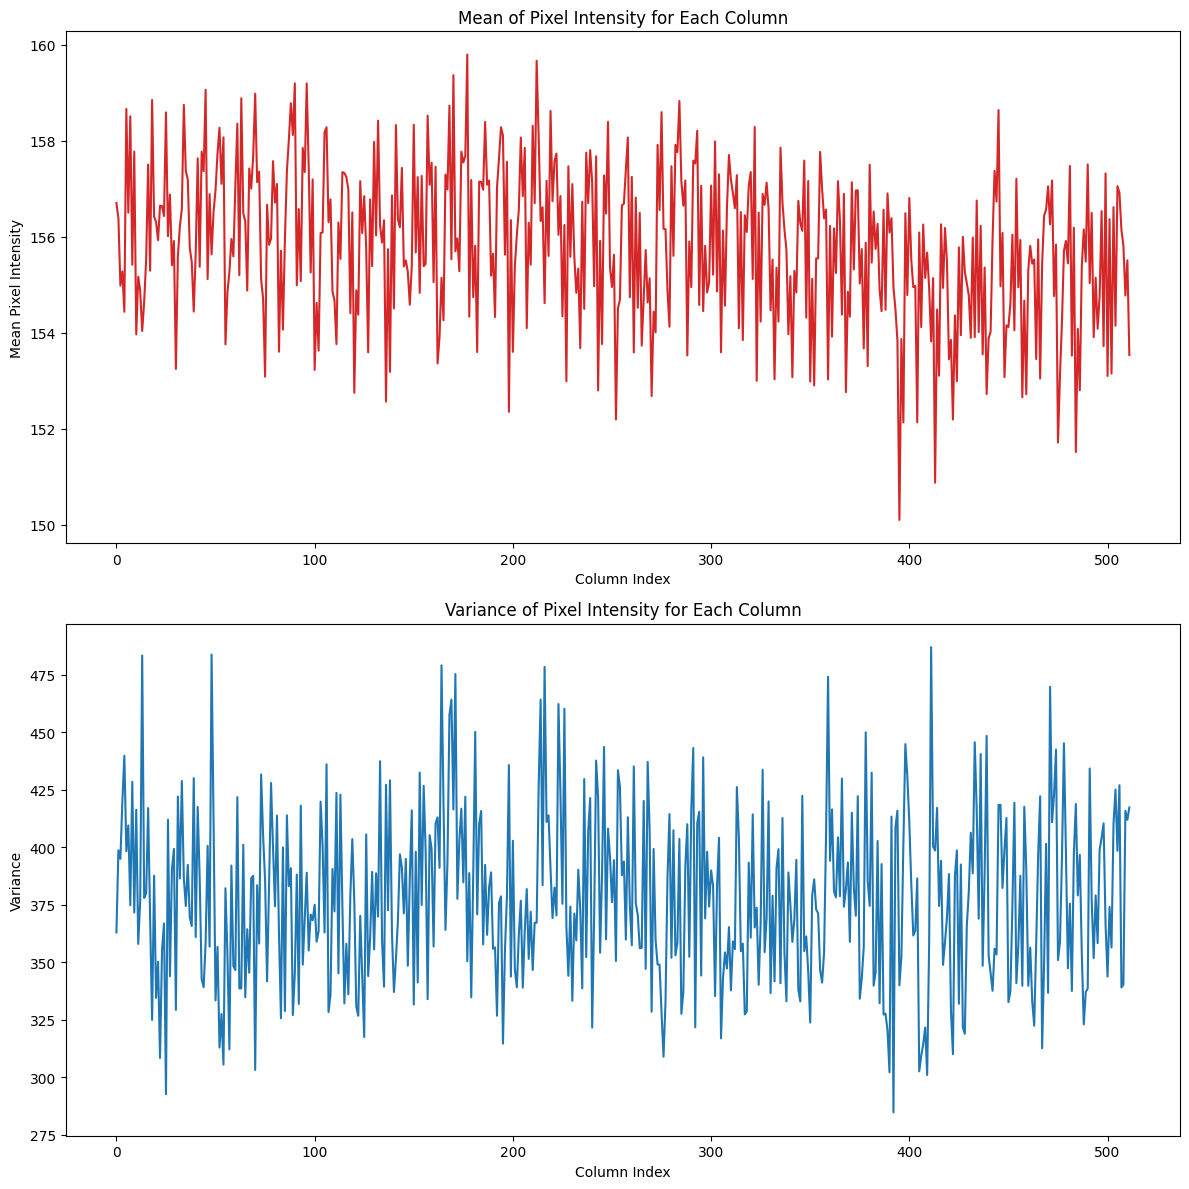

In [55]:
# Calculate the mean and variance for each column of the image
columns_mean = np.mean(gray_image, axis=0)
columns_variance = np.var(gray_image, axis=0)

# Plot the mean and variance for each column in separate plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot for mean
ax1.set_xlabel('Column Index')
ax1.set_ylabel('Mean Pixel Intensity')
ax1.plot(columns_mean, color='tab:red')
ax1.set_title('Mean of Pixel Intensity for Each Column')

# Plot for variance
ax2.set_xlabel('Column Index')
ax2.set_ylabel('Variance')
ax2.plot(columns_variance, color='tab:blue')
ax2.set_title('Variance of Pixel Intensity for Each Column')

fig.tight_layout()
plt.show()


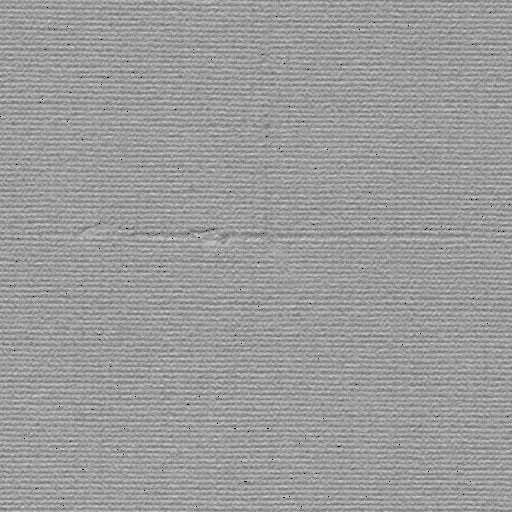

In [56]:
# Calculate the mean and variance for each column of the image
columns_mean = np.mean(gray_image_array, axis=0)
columns_variance = np.var(gray_image_array, axis=0)

# Identify columns with out-of-control pixel values using 3-sigma rule
control_limit_columns = 3 * np.sqrt(columns_variance)
upper_control_limit_columns = columns_mean + control_limit_columns
lower_control_limit_columns = columns_mean - control_limit_columns

modified_image_columns_matrix = []
for j, column in enumerate(gray_image_array.T):  # Transpose to iterate over columns
    out_of_control_columns = np.logical_or(column > upper_control_limit_columns[j], column < lower_control_limit_columns[j])
    modified_image_columns_matrix.append(out_of_control_columns)

modified_image_columns_array = np.array(modified_image_columns_matrix).T  # Transpose back to original orientation
modified_pixels_columns = pixel_values.copy()

modified_image_columns_matrix_flat = modified_image_columns_array.flatten()
modified_pixels_columns[modified_image_columns_matrix_flat] = 0

modified_image_columns = modified_pixels_columns.reshape(gray_image.size[::-1])
modified_image_columns = Image.fromarray(modified_image_columns)

# Display the modified image
display(modified_image_columns)

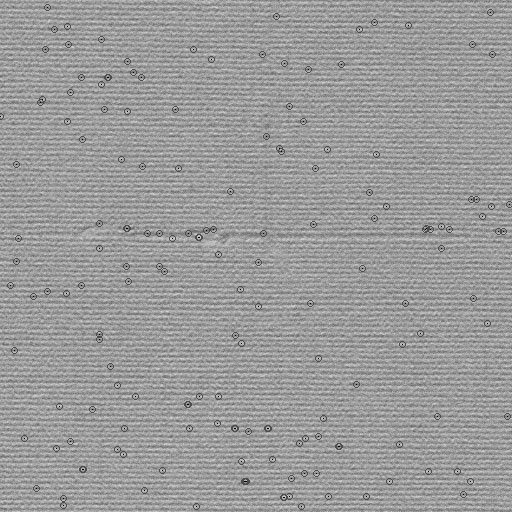

In [57]:
DrawCircle(modified_image_columns,modified_pixels_columns)